In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

# MNIST

In [2]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root='./data', train=True, transform=trans, download=True)
test_set = dset.MNIST(root='./data', train=False, transform=trans)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 2056743.54it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 208107.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1002322.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1588073.42it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
BATCH_SIZE=64
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

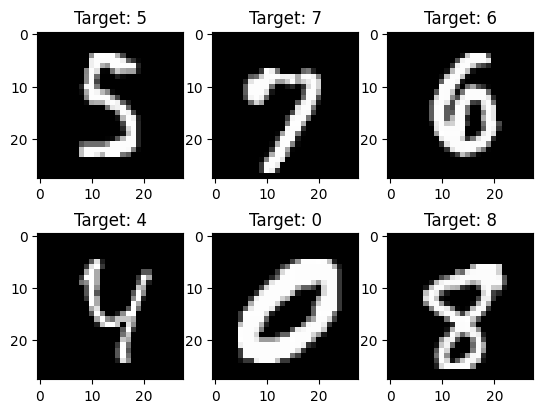

In [4]:
first_batch=next(iter(train_loader))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(first_batch[0][i][0], cmap='gray')
    plt.title(f"Target: {first_batch[1][i].item()}")
plt.show()

In [5]:
print("data shape  :",train_loader.dataset.data.size())
print("label shape :",train_loader.dataset.targets.size())
print("batch size  :",train_loader.batch_size)

data shape  : torch.Size([60000, 28, 28])
label shape : torch.Size([60000])
batch size  : 64


# ALEXNET

In [6]:
NCLASSES=10

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=1, stride=1),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 3 * 3, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, NCLASSES),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 3 * 3)
        x = self.classifier(x)
        return x

In [7]:
def test(model, test_loader, criterion):
    model.eval()
    test_losses = []
    test_accuracies = []
    

    for _, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        test_accuracies.append(accuracy)

    return test_losses, test_accuracies

In [8]:
EPOCHS=2

def train(model, train_loader, optimizer, criterion):
    train_losses = []
    test_losses = []
    test_accuracies = []

    model.train()

    for epoch in range(EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            if i%100==0:
            
                tl, ta = test(model, test_loader, criterion)
                test_losses.extend(tl)
                test_accuracies.extend(ta)

                print(f'Epoch {epoch+1}/{EPOCHS}, Step {i+1}/{len(train_loader)}\n - Train Loss: {loss.item()}')
                print(f' - Test Loss: {tl[-1]}\n - Test Accuracy: {ta[-1]}')

            if sum(test_accuracies[-3:])/3 > 0.95:
                print('Performance condition satisfied.')
                return train_losses, test_losses, test_accuracies
            

    return train_losses, test_losses, test_accuracies


In [9]:
model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/2, Step 1/938
 - Train Loss: 2.3008406162261963
 - Test Loss: 2.3053269386291504
 - Test Accuracy: 0.125
Epoch 1/2, Step 101/938
 - Train Loss: 1.281026840209961
 - Test Loss: 1.1771585941314697
 - Test Accuracy: 0.4375
Epoch 1/2, Step 201/938
 - Train Loss: 0.6685462594032288
 - Test Loss: 0.1611413061618805
 - Test Accuracy: 0.9375
Epoch 1/2, Step 301/938
 - Train Loss: 0.0645895004272461
 - Test Loss: 0.15128657221794128
 - Test Accuracy: 0.9375
Epoch 1/2, Step 401/938
 - Train Loss: 0.06364698708057404
 - Test Loss: 0.04708755761384964
 - Test Accuracy: 1.0
Epoch 1/2, Step 501/938
 - Train Loss: 0.1363777369260788
 - Test Loss: 0.00464418763294816
 - Test Accuracy: 1.0
Performance condition satisfied.


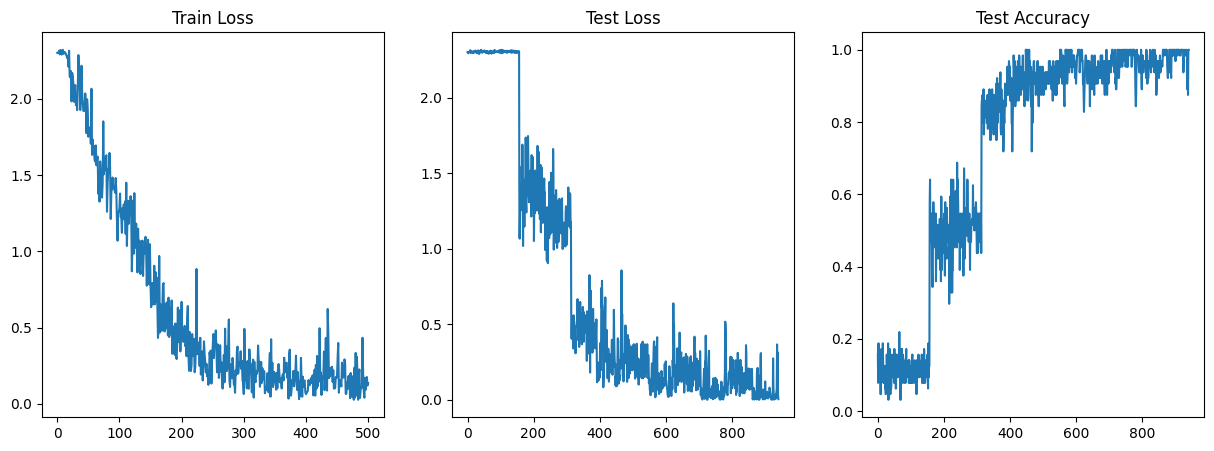

Average Test Loss: 0.7358105118247292
Average Test Accuracy: 0.7249701433121019


In [10]:
losses, test_losses, test_accuracies = train(model, train_loader, optimizer, criterion)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Train Loss")

plt.subplot(1, 3, 2)
plt.plot(test_losses)
plt.title("Test Loss")

plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.show()


print(f"Average Test Loss: {sum(test_losses)/len(test_losses)}")
print(f"Average Test Accuracy: {sum(test_accuracies)/len(test_accuracies)}")

In [11]:
# one whole eval
model.eval()
correct = 0
total = 0

for images, labels in test_loader:
    images = Variable(images)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print(f'Accuracy of the network on the {len(test_loader)} test images: {100 * correct / total}%')


Accuracy of the network on the 157 test images: 97.08999633789062%


# EXAMPLES PREDICTION

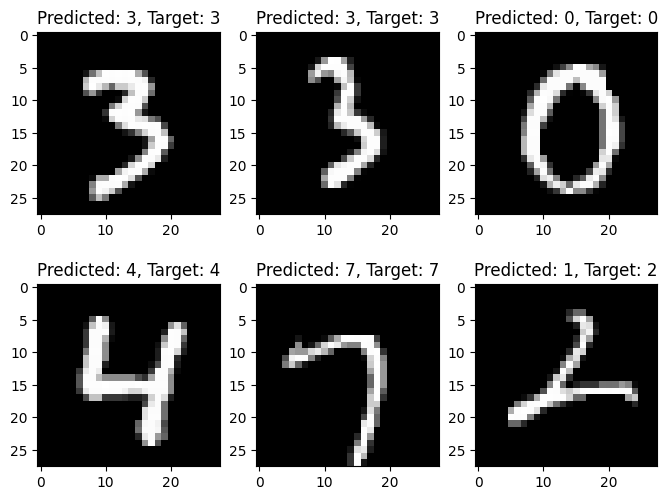

In [12]:
batch = next(iter(test_loader))
images, labels = batch

outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

plt.figure(figsize=(8, 6))
for i in range(6):
    random_idx = torch.randint(0, BATCH_SIZE, (1,)).item()
    plt.subplot(2, 3, i+1)
    plt.imshow(images[random_idx][0], cmap='gray')
    plt.title(f'Predicted: {predicted[random_idx]}, Target: {labels[random_idx]}')